## Importing breast cancer dataset

In [1]:
#pip install --upgrade tensorflow==2.9.0

The content of the breast cancer dataset is:
['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']
-------------------------
inputs =  (569, 30)
outputs =  (569,)
labels =  (30,)


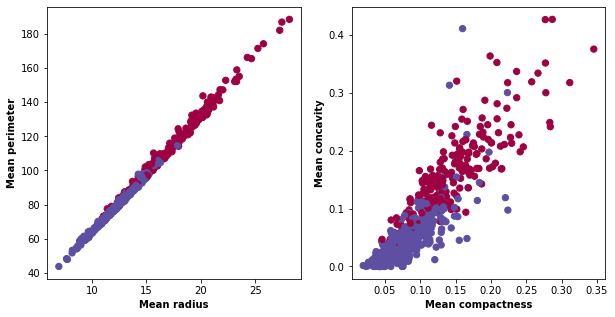

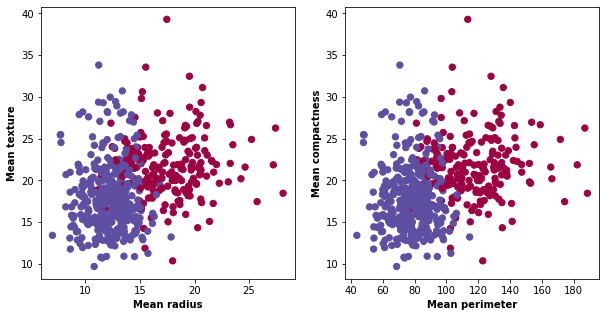

In [12]:
### Code for importing and treating dataset borrowed from lect notes (14.11.22)
import tensorflow.python as tf
from tensorflow.python import keras
from keras.layers import Input
from keras.models import Sequential      #This allows appending layers to existing models
from keras.layers import Dense           #This allows defining the characteristics of a particular layer
from keras import optimizers             #This allows using whichever optimiser we want (sgd,adam,RMSprop)
from keras import regularizers           #This allows using whichever regularizer we want (l1,l2,l1_l2)
#from keras.utils import to_categorical   #This allows using categorical cross entropy as the cost function
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split as splitter
from sklearn.datasets import load_breast_cancer
import pickle
import os
from sklearn.metrics import accuracy_score
from p2_functions import MSE, create_X, sigmoid, RELU, to_categorical_numpy


"""Load breast cancer dataset"""

np.random.seed(0)        #create same seed for random number every time

cancer=load_breast_cancer()      #Download breast cancer dataset

inputs=cancer.data                     #Feature matrix of 569 rows (samples) and 30 columns (parameters)
outputs=cancer.target                  #Label array of 569 rows (0 for benign and 1 for malignant)
labels=cancer.feature_names[0:30]

print('The content of the breast cancer dataset is:')      #Print information about the datasets
print(labels)
print('-------------------------')
print("inputs =  " + str(inputs.shape))
print("outputs =  " + str(outputs.shape))
print("labels =  "+ str(labels.shape))

x=inputs      #Reassign the Feature and Label matrices to other variables
y=outputs

# Visualisation of dataset (for correlation analysis)

plt.figure(figsize = (10, 5))
plt.subplot(1, 2, 1)
plt.scatter(x[:, 0], x[:, 2], s=40, c=y, cmap=plt.cm.Spectral)
plt.xlabel('Mean radius', fontweight='bold')
plt.ylabel('Mean perimeter', fontweight='bold')

plt.subplot(1, 2, 2)
plt.scatter(x[:, 5], x[:, 6], s=40, c=y, cmap=plt.cm.Spectral)
plt.xlabel('Mean compactness', fontweight='bold')
plt.ylabel('Mean concavity', fontweight='bold')
plt.show()

plt.figure(figsize = (10, 5))
plt.subplot(1, 2, 1)
plt.scatter(x[:, 0], x[:, 1], s=40, c=y, cmap=plt.cm.Spectral)
plt.xlabel('Mean radius', fontweight='bold')
plt.ylabel('Mean texture', fontweight='bold')

plt.subplot(1, 2, 2)
plt.scatter(x[:, 2], x[:, 1], s=40, c=y, cmap=plt.cm.Spectral)
plt.xlabel('Mean perimeter', fontweight='bold')
plt.ylabel('Mean compactness', fontweight='bold')
plt.show()

## Classification FFNN script

In [3]:
# Generate training and testing datasets

# Select features relevant to classification (texture,perimeter,compactness and symmetery)
# and add to input matrix

temp1 = np.reshape(x[:, 1], (len(x[:, 1]), 1))
temp2 = np.reshape(x[:, 2], (len(x[:, 2]), 1))
X = np.hstack((temp1, temp2))
temp = np.reshape(x[:, 5], (len(x[:, 5]), 1))
X = np.hstack((X, temp))
temp = np.reshape(x[:, 8], (len(x[:, 8]), 1))
X = np.hstack((X, temp))

X_train, X_test, y_train, y_test = splitter(X, np.ravel(y).reshape(-1,1), test_size=0.2)  # Split datasets into training and testing


del temp1, temp2, temp

Y_train_onehot, Y_test_onehot = to_categorical_numpy(y_train), to_categorical_numpy(y_test)

In [4]:
def Initialize(var, bias):
    # Initialize a set of hidden/output weights/biases
    # weights and bias in the hidden layer
    hidden_weights = np.random.randn(n_features, n_hidden_neurons)*var
    hidden_bias = np.zeros(n_hidden_neurons) + bias

    # weights and bias in the output layer
    output_weights = np.random.randn(n_hidden_neurons, n_categories)*var
    output_bias = np.zeros(n_categories) + bias
    return hidden_weights, hidden_bias, output_weights, output_bias

# implement if statement for different activation
# activation inputs: 'sigmoid', 'relu', 'leaky relu', 'tanh'
def feed_forward(X, hidden_weights, output_weights, activation = 'Sigmoid'): # modified for regression
    # weighted sum of inputs to the hidden layer
    z_h = np.matmul(X, hidden_weights) 
    
    # activation in the hidden layer 
    if activation == 'Sigmoid':
        a_h = sigmoid(z_h)
    elif activation == 'Leaky RELU':
        a_h = RELU(z_h)
    elif activation == 'RELU':
        a_h = RELU(z_h, a = 0)
    elif activation == 'Tanh':
        a_h = np.tanh(z_h)
    
    # weighted sum of inputs to the output layer
    z_o = np.matmul(a_h, output_weights)
    # softmax output
    # axis 0 holds each input and axis 1 the probabilities of each category
    exp_term = np.exp(z_o)
    probabilities = exp_term / np.sum(exp_term, axis=1, keepdims=True)
    
    # for backpropagation need activations in hidden and output layers
    return a_h, probabilities

def backpropagation(X, Y, activation, hidden_weights, output_weights):
    # Feed forward pass
    a_h, probabilities = feed_forward(X, hidden_weights, output_weights, activation)
    
    # error in the output layer
    # scaled with amount of data to prevent numerical errors at large generated weights
    # cross entropy loss function
    error_output = (probabilities - Y)/(probabilities*(1 - probabilities))
    error_output = error_output/Y.shape[0]
    # error in the hidden layer
    error_hidden = np.matmul(error_output, output_weights.T) * a_h * (1 - a_h)
    
    # gradients for the output layer
    output_weights_gradient = np.matmul(a_h.T, error_output)
    output_bias_gradient = np.sum(error_output, axis=0)
    
    # gradient for the hidden layer
    hidden_weights_gradient = np.matmul(X.T, error_hidden)
    hidden_bias_gradient = np.sum(error_hidden, axis=0)

    return output_weights_gradient, output_bias_gradient, hidden_weights_gradient, hidden_bias_gradient, probabilities

In [5]:
n_inputs, n_features = X_train.shape
n_hidden_neurons = 20 #start with few neurons
h = 1 #nr of hidden layers
n_categories = 2

### Complete FFNN architecture with backpropagation
def FFNN(X, Y, activation, epochs = 300, eta = 0.3, lmbd = 0.01):
    # Initialize weights and biases
    hidden_weights, hidden_bias, output_weights, output_bias = Initialize(var = 0.01, bias = 0.01)
    acc_NN = np.zeros(epochs) # save accuracy every step
    
    # Network training
    for i in range(epochs):
        # calculate gradients
        dWo, dBo, dWh, dBh, probabilities = backpropagation(X, Y, activation, hidden_weights, output_weights)

        # regularization term gradients
        dWo += lmbd * output_weights
        dWh += lmbd * hidden_weights

        # update weights and biases
        output_weights -= eta * dWo
        output_bias -= eta * dBo
        hidden_weights -= eta * dWh
        hidden_bias -= eta * dBh

        # save accuracy for each step
        predict = np.argmax(probabilities, axis=1)
        acc_NN[i] = accuracy_score(y_train, predict)
    
    # Plotting MSE for each epoch step
    epoch = np.linspace(0, epochs, epochs)
    plt.plot(epoch, acc_NN, lw = 3, 
    label = f'{activation}, $\eta = {eta}$, $\lambda = {lmbd}$, '+'$Accuracy max$ = '+f'{round(np.max(acc_NN),3)}')
    return epoch, acc_NN, probabilities

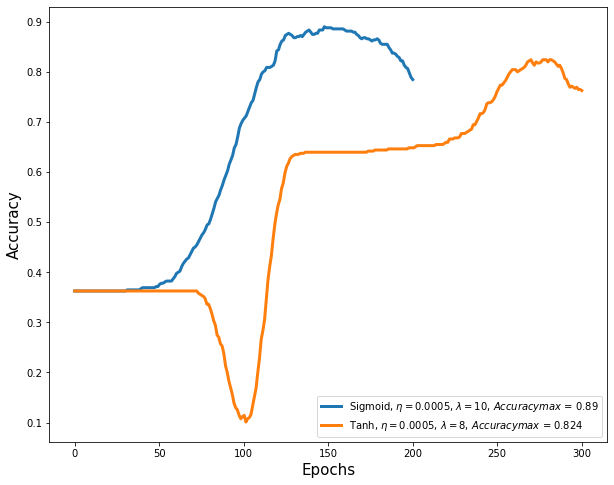

In [6]:
plt.figure(figsize = (10, 8))
plt.xlabel('Epochs', fontsize = 15)
plt.ylabel('Accuracy', fontsize = 15)
e1, m1, p1 = FFNN(X_train, y_train, 'Sigmoid', epochs = 200, lmbd = 10, eta = 0.0005)
e1, m1, p1 = FFNN(X_train, y_train, 'Tanh', epochs = 300, lmbd = 8, eta = 0.0005)
plt.legend(); plt.show()

In [7]:
print(np.shape(p1))
#print(p1)

(455, 2)


## Keras classification network

In [8]:
#pip install keras==2.9.0

In [20]:
# Creating the same architecture
model = Sequential()
# Hidden layer and input
model.add(Dense(20, input_shape = (X_train.shape[1],), activation = 'sigmoid',
               kernel_regularizer = regularizers.L1(1)))
#output layer
model.add(Dense(1, activation = 'softmax'))

print(y_train.shape)
print(X_train.shape)

# Compile, fit and evaluate
opt = optimizers.SGD(learning_rate=0.5)
regulizers = ()
model.compile(loss = 'binary_crossentropy', optimizer = opt, metrics=['accuracy'])
model.fit(X_train, y_train, epochs = 400, batch_size = 0, verbose = 0)
loss, acc = model.evaluate(X_test, y_test)

(455, 1)
(455, 4)
4/4 [==============================] - 0s 2ms/step - loss: 21.1643 - accuracy: 0.5877


We get the same accuracy every run (0.5877), probably constructed wrong.

## Logistic regression of cancer data (task E)

In [10]:
# first using sklearn method
from sklearn.linear_model import LogisticRegression

model_ = LogisticRegression()
model_.fit(X_train, y_train.ravel())
model_.predict(X_test)
print(f'Accuracy score: {model_.score(X_test, y_test)}')

Accuracy score: 0.9122807017543859


In [11]:
# our own code ...